# ***Decision Tree 决策树***

# QA
----
## **1.采用信息增益、信息增益率作为决策树生⻓策略，有什么区别？**
### a. ID3算法采用信息增益作为特征选择的标准，而C4.5作为ID3的改进使用了信息增益率作为标准。这一改变是为了解决在ID3算法中出现的，信息增益主导的特征选择偏向取值更多的特征的问题。
### b. 对于信息增益的计算，分布相同的情况下，取值更多的特征的信息增益更大，但是他们本来都是不确定的，不应该有一方偏大。特别是对于连续量或者取值很多的离散量的情况下这个问题比较严重，极限情况下条件熵趋于0，使得信息增益明显偏大。
### c. 而信息增益率是信息增益除以特征熵，特征取值越多其熵也越大，能够一定程度矫正前面的问题。


-----

## **2. 其他条件一致，对样本某变量进行单调非线性变化，是否会影响决策树生⻓，为什么？**
### 只要变化是单调的应该就不会。以C4.5算法为例，如果该特征是离散的，那么特征具体取值的变化不会影响条件熵和特征熵以及信息增益的计算，从而不会影响决策树生长。如果该特征是连续的，也需要进行离散化处理，也是取两两相邻样本值的平均作为二分点，所以只要变化是单调的，这里的划分情况都和原来没有区别。

----

## **3.随机森林参数有哪些重要的参数，分别的作用是什么？**
### a. 决策树个数n_esitinators:决策树的个数，太少容易欠拟合，太多计算量太大。
### b. 最大特征数max_features:每棵树选择建立模型的最多特征数。由于模型每个节点随机采用部分特征n_sub用于决策树训练，这个参数决定了n_sub的最大值。n_sub越小，则模型越健壮，当然此时对于训练集的拟合程度会变差。也就是说nsub越小，模型的方差会减小，但是偏倚会增大。
### c. 树最大深度max_depth:决定每棵树的最大深度。一般来说，数据少或者特征少的时候可以不管这个值。如果模型样本量多，特征也多的情况下，推荐限制这个最大深度，具体的取值取决于数据的分布。常用的可以取值10-100之间。
### d. 最大叶子结点数mas_leaf_nodes:一般情况下，决策树的深度越深，叶节点个数越多，树的复杂度越高。随机森林的复杂度与训练样本数和树的个数成正比。

----

## **4. 多个模型预测结果做Average融合，模型间具备怎样的特点会取得更好的效果？**
### 模型最好互不相同，这样各模型的误差相关性低，不会造成错误的叠加，



# ***Titanic***
## test survival on the Titanic
## 尝试用随机森林提交预测结果，并调整模型参数提升成绩
## 尝试利用Average融合思路设计随机森林&逻辑回归融合



In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

----
## 1. 在1.2处理好的数据基础上进行随机森林分类
### 观察并选择特征，做好处理。进行随机森林分类并调优。

In [4]:
train=pd.read_csv('train_processed.csv')
test=pd.read_csv('test_precessed.csv')
train.isnull().sum()
test.isnull().sum()

### 共线性对决策树和随机森林有影响吗

一般来说做线性回归或其他回归问题前会做共线性检验，如果存在比较严重的共线性问题时要用特定算法或者降维处理。而决策树和随机森林的预测能力不受多重共线性影响。

但是决策树和随机森林的数据解释性会被多重共线性影响。随机森林可以返回特征的重要性（importantce），当有多重共线性时，importance会被影响。一些具体多重共线性的特征的重要性会被相互抵消，从而影响我们解释和理解特征。比如说，特征A和B完全一样，我们在用随机森林时，它们的重要性应该非常接近（考虑到随机性）。如果我们在训练前删除特征B，那么特征A的重要性就会翻番。这一下子就影响了我们对特征、数据的理解。

考虑到两个亲友关系特征的共线性关系，进行降维处理。

In [6]:
train=pd.read_csv('train_processed.csv')
test=pd.read_csv('test_precessed.csv')
train.isnull().sum()
test.isnull().sum()
pca=PCA(n_components=1)
ncol=pca.fit_transform(train[['SibSp','Parch']])
train["Companion"]=ncol
pca=PCA(n_components=1)
ncol=pca.fit_transform(test[['SibSp','Parch']])
test["Companion"]=ncol

df_train = pd.get_dummies(train, columns=["Pclass","Embarked","Sex"])
df_train.drop('Sex_female', axis=1, inplace=True)
df_train.drop('PassengerId', axis=1, inplace=True)
df_train.drop('Ticket', axis=1, inplace=True)
df_train.drop('SibSp', axis=1, inplace=True)
df_train.drop('Parch', axis=1, inplace=True)

df_test = pd.get_dummies(test, columns=["Pclass","Embarked","Sex"])
df_test.drop('Sex_female', axis=1, inplace=True)
df_test.drop('PassengerId', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)
df_test.drop('SibSp', axis=1, inplace=True)
df_test.drop('Parch', axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()
y = df_train.Survived
df_train = scaler.fit_transform(df_train.drop('Survived',axis=1))
df_test = scaler.transform(df_test)
X = df_train



先调试框架参数

In [13]:
estimator = RandomForestClassifier()
# test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(test_size, y, test_size=test_size, random_state=9)

params0 = {'n_estimators': range(1, 200 ,10)}

grid_search0 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params0, 
                        scoring='roc_auc')
grid_search0.fit(X,y)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': range(1, 200, 10)},
             return_train_score=True, scoring='roc_auc')

In [19]:
grid_search0.best_score_, grid_search0.best_params_

(0.8635302987641733, {'n_estimators': 161})

In [35]:
rf_clf0 = RandomForestClassifier(n_estimators=161, oob_score=True)
rf_clf0.fit(X,y).oob_score_


0.8114478114478114

下面调试树参数

In [39]:
estimator = RandomForestClassifier(n_estimators=161)
# test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(test_size, y, test_size=test_size, random_state=9)

params1 = {'max_depth':range(3,20,2),
        'min_samples_split':range(1,20,2),
        'min_samples_leaf':range(1,3)}

grid_search1 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params1, 
                        scoring='roc_auc')
grid_search1.fit(X,y)

D:\programs\envs\python36\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.85666534 0.8570589  0.85568956 0.85633378 0.85429838
 0.85551785 0.8549406  0.85451379 0.85639632        nan 0.86086227
 0.85598736 0.85522775 0.85620154 0.85508796 0.85644797 0.86059974
 0.85488787 0.85557713        nan 0.87069391 0.8680906  0.86924241
 0.87060769 0.87091289 0.86834387 0.86766148 0.86898389 0.86850377
        nan 0.86746304 0.86877518 0.86842911 0.86727324 0.86946232
 0.86815754 0.86611732 0.8662131  0.86834571        nan 0.87195687
 0.87032395 0.86902788 0.87041639 0.87082012 0.874207   0.87387758
 0.87084599 0.87047921        nan 0.86910282 0.87189549 0.86951229
 0.87235929 0.87187026 0.8691537  0.87084293 0.86780795 0.87307147
        nan 0.873018   0.87513804 0.87344178 0.87499587 0.87425941
 0.87410969 0.87450848 0.87550655 0.87531731        nan 0.87234978
 0.87432631 0.87335295 0.8751648  0.87315934 0.87581

GridSearchCV(estimator=RandomForestClassifier(n_estimators=161), n_jobs=-1,
             param_grid={'max_depth': range(3, 20, 2),
                         'min_samples_leaf': range(1, 3),
                         'min_samples_split': range(1, 20, 2)},
             return_train_score=True, scoring='roc_auc')

In [40]:
grid_search1.best_score_, grid_search1.best_params_

(0.8808348993584451,
 {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 17})

In [14]:
rf_clf1 = RandomForestClassifier(n_estimators=161, oob_score=True,max_depth=15, min_samples_leaf=1, min_samples_split=17)
rf_clf1.fit(X,y).oob_score_

0.819304152637486

进一步调节

In [15]:
estimator = RandomForestClassifier(n_estimators=161,
                                oob_score=True,
                                max_depth=15, 
                                min_samples_leaf=1, 
                                min_samples_split=17)
# test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(test_size, y, test_size=test_size, random_state=9)

params2 = {'max_features':['sqrt', 'log2', 'auto'],
        'criterion':['gini', 'entropy']}

grid_search2 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params2, 
                        scoring='roc_auc')
grid_search2.fit(X,y)
grid_search2.best_score_, grid_search2.best_params_

(0.8792135887607391, {'criterion': 'entropy', 'max_features': 'auto'})

In [17]:
rf_clf2 = RandomForestClassifier(n_estimators=161, oob_score=True,max_depth=15, min_samples_leaf=1, min_samples_split=17,
                                max_features='auto', criterion='entropy')
rf_clf2.fit(X,y).oob_score_

0.8327721661054994

In [112]:
record=pd.DataFrame(grid_result.cv_results_)

In [58]:
pred_result=rf_clf2.predict(df_test)

In [59]:
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':pred_result}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('submission_7.csv')

----
## 2. 逻辑回归与随机森林模型averaging融合
### 先构建逻辑回归，然后保存两者预测概率，再观察两者预测概率结果的相关性


In [40]:
train1=pd.read_csv('train_processed.csv')
test1=pd.read_csv('test_precessed.csv')
pca=PCA(n_components=1)
ncol=pca.fit_transform(train1[['SibSp','Parch']])
train1["Companion"]=ncol
pca=PCA(n_components=1)
ncol=pca.fit_transform(test1[['SibSp','Parch']])
test1["Companion"]=ncol
df_train1 = pd.get_dummies(train1, columns=["Pclass","Embarked","Sex"])
df_train1.drop('Sex_female', axis=1, inplace=True)
df_train1.drop('PassengerId', axis=1, inplace=True)
df_train1.drop('Ticket', axis=1, inplace=True)
df_train1.drop('SibSp', axis=1, inplace=True)
df_train1.drop('Parch', axis=1, inplace=True)
df_test1 = pd.get_dummies(test1, columns=["Pclass","Embarked","Sex"])
df_test1.drop('Sex_female', axis=1, inplace=True)
df_test1.drop('PassengerId', axis=1, inplace=True)
df_test1.drop('Ticket', axis=1, inplace=True)
df_test1.drop('SibSp', axis=1, inplace=True)
df_test1.drop('Parch', axis=1, inplace=True)
picked_features = ['Age', 'Companion', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_male']\


X1 = df_train1[picked_features]
y = df_train1.Survived
df_test1=df_test1[picked_features]
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
df_test1 = scaler.transform(df_test1)


from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X1, y)
result=model.predict_proba(df_test1)[:,1]
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':result}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('prob_logistic.csv')
pred_prob=rf_clf2.predict_proba(df_test)[:,1]
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':pred_prob}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('prob_rf.csv')



prob_logistic = pd.read_csv('prob_logistic.csv')
prob_rf = pd.read_csv('prob_rf.csv')
prob_logistic['logistic']=prob_logistic['Survived']
prob_logistic.drop('Survived',axis=1,inplace=True)
prob_rf['rf'] = prob_rf['Survived']
prob_rf.drop('Survived',axis=1,inplace=True)

prob_logistic['rf']=prob_rf['rf']
n_df=prob_logistic.drop(['PassengerId'], axis=1)

<AxesSubplot:>

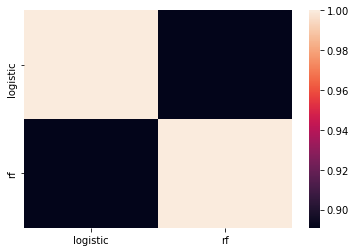

In [52]:
sns.heatmap(n_df.corr())

可以看到两种分类模型得到的结果相关性很强。还是尝试一下融合，考虑到两个模型相关性较高，另一方面分类结果得分也很相近，认为效果基本一致，所以融合取平均。

In [58]:
n_col = (n_df.rf + n_df.logistic).values/2
ensemble_result = [int(i>=0.5) for i in n_col]

In [60]:
temp=pd.read_csv('test.csv')
submission={'PassengerId':temp.PassengerId,'Survived':ensemble_result}
df_submission=pd.DataFrame(submission)
df_submission.to_csv('ensemble_submission8.csv')